In [15]:
import numpy as np
import numpy.ma as ma
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

#from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
#rc('text', usetex=True)

import pandas as pd
import datetime

import pymc3 as pm

import pickle
import datetime

import theano
import theano.tensor as tt
theano.config.gcc.cxxflags = "-Wno-c++11-narrowing"

def _format_k(prec):
    """
        format yaxis 10_000 as 10 k.
        _format_k(0)(1200, 1000.0) gives "1 k"
        _format_k(1)(1200, 1000.0) gives "1.2 k"
    """

    def inner(xval, tickpos):
        return f"${xval/1_000:.{prec}f}\,$k"

    return inner

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)

In [16]:
with open("data/onset_by_date.pickle","rb") as f:
    onsets_per_date = pickle.load(f)

with open("data/onsets_by_date_diff.pickle","rb") as f:
    onsets_per_date_diff = pickle.load(f)
    
publishing_start = datetime.date(2020,3,4)  # Startdate of epicurves, first occurence in situation-report
onset_start = datetime.date(2020,2,16)    # Startdate of known onsets
onset_diff_start = onset_start + datetime.timedelta(days=1)
    
# Import KRI Nowcasting csv
def rdate(s):
    r = None
    if "T" in s:
        r = datetime.datetime.strptime(s.split("T")[0],"%Y-%m-%d")
    if "-" in s:
        r = datetime.datetime.strptime(s.split(" ")[0],"%Y-%m-%d")
    else:
        if s[:4] == "2020":
            r = datetime.datetime.strptime(s.split(" ")[0],"%Y/%m/%d")
        else:
            r = datetime.datetime.strptime(s.split(" ")[0],"%m/%d/%Y")
    return r.date()

nowcast_df = pd.read_csv("data/Nowcasting_Zahlen_200528.csv", sep=",") 
ck = nowcast_df.columns
# Renaming of columns
nowcast_df = nowcast_df.rename(columns={ck[0]:"date",ck[1]:"new_infected",ck[2]:"new_infected_low",ck[3]:"new_infected_high"})
nowcast_df = nowcast_df.rename(columns={ck[4]:"new_infected_smooth",ck[5]:"new_infected_smooth_low",ck[6]:"new_infected_smooth_high"})
nowcast_df = nowcast_df.rename(columns={ck[7]:"R_4",ck[8]:"R_4_low",ck[9]:"R_4_high"})
nowcast_df = nowcast_df.rename(columns={ck[10]:"R_4",ck[11]:"R_4_low",ck[12]:"R_4_high"})
# Generate proper timestamps
nowcast_df["date"] = nowcast_df["date"].apply(rdate)

print(nowcast_df.columns)
print(onsets_per_date.shape,onsets_per_date_diff.shape)
print(type(onsets_per_date))

Index(['date', 'new_infected', 'new_infected_low', 'new_infected_high',
       'new_infected_smooth', 'new_infected_smooth_low',
       'new_infected_smooth_high', 'R_4', 'R_4_low', 'R_4_high', 'R_4',
       'R_4_low', 'R_4_high'],
      dtype='object')
(102, 85) (104, 86)
<class 'numpy.ma.core.MaskedArray'>


In [17]:
# Parse RKI DB_dump to get Meldedatums
rki_df = pd.read_csv("data/RKI_COVID19_200527.csv", sep=",") 

cols = [x for x in ["Meldedatum","Refdatum"] if x in rki_df.columns]
for col in cols:
    if col in rki_df:
        rki_df[col] = rki_df[col].apply(rdate)
        
rki_df = rki_df.filter(items=["Meldedatum","Refdatum","NeuerFall","AnzahlFall","IstErkrankungsbeginn"])


In [18]:
# Generate KWs
kw09_start = datetime.date(2020,3,2)
KWs,KWss = {},{}
for i in range(9,21):
    KWs[i] = kw09_start+datetime.timedelta(days=7*(i-9))
    KWss[i] = KWs[i].strftime('%b %d') + " - " + (KWs[i] + datetime.timedelta(days=6)).strftime('%b %d')

# Collect per KW series of known onsets
by_onset_in_kw,by_publication_in_kw = {},{}

for ikw,sdate in KWs.items():
    by_onsets,by_publication = np.zeros(60),np.zeros(60)
    
    onset_i = (sdate-onset_start).days
    pub_i = (sdate-publishing_start).days-1 # Offset as onsets_per_date_diff starts 1 day later
    for i in range(7):
        onset_ii = onset_i+i
        if onset_ii >= 0 and onset_ii < onsets_per_date_diff.shape[0]:
            for j in range(60):
                pub_jj = pub_i + j + i
                if pub_jj >= 0 and pub_jj < onsets_per_date_diff.shape[1]:
            #        print(onset_i,pub_i,"\t",i,j,"\t",onset_ii,pub_jj)
                    by_onsets[j] += onsets_per_date_diff[onset_ii,pub_jj]
    by_onset_in_kw[ikw] = by_onsets


In [19]:
# Count Onsets and Meldungen per KW from RKI DB_dump
melde_delay_by_onset,melde_delay_by_meldung = {},{}
max_range = 60
for i,k in enumerate(sorted(KWs.keys())):
    start = KWs[k]
    end = start + datetime.timedelta(days=7)
    
    rki_meld_week = rki_df[(rki_df["Meldedatum"] >= start) & (rki_df["Meldedatum"] < end )]
    rki_ref_week = rki_df[(rki_df["Refdatum"] >= start) & (rki_df["Refdatum"] < end)]
    
    odelay,mduration = np.zeros(max_range),np.zeros(max_range)
    # Count Duration between Onset and Meldung by Meldungen in one KW
    for i,x in rki_meld_week.iterrows():
 #       if x["IstErkrankungsbeginn"] and x["NeuerFall"] != -9:
        if x["Meldedatum"] != x["Refdatum"] and x["NeuerFall"] != -9:
            delay = (x["Meldedatum"] - x["Refdatum"]).days
            if delay >= 0 and delay < max_range:
                mduration[delay] += x["AnzahlFall"]
    melde_delay_by_meldung[k] = mduration
    # Count Delay between Onset and Meldung by Onset in one KW
    for i,x in rki_ref_week.iterrows():
        if x["Meldedatum"] != x["Refdatum"] and x["NeuerFall"] != -9:
      #  if x["IstErkrankungsbeginn"] and x["NeuerFall"] != -9:
            delay = (x["Meldedatum"] - x["Refdatum"]).days
            if delay >= 0 and delay < max_range:
                odelay[delay] += x["AnzahlFall"]
    melde_delay_by_onset[k] = odelay

# Delay between known onsets and publication in RKI dataset per KW

{9: {0.2: 6, 0.5: 12, 0.8: 22}, 10: {0.2: 6, 0.5: 11, 0.8: 19}, 11: {0.2: 6, 0.5: 10, 0.8: 18}, 12: {0.2: 5, 0.5: 9, 0.8: 16}, 13: {0.2: 4, 0.5: 7, 0.8: 14}, 14: {0.2: 4, 0.5: 7, 0.8: 13}, 15: {0.2: 3, 0.5: 6, 0.8: 11}}
dict_keys([9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])


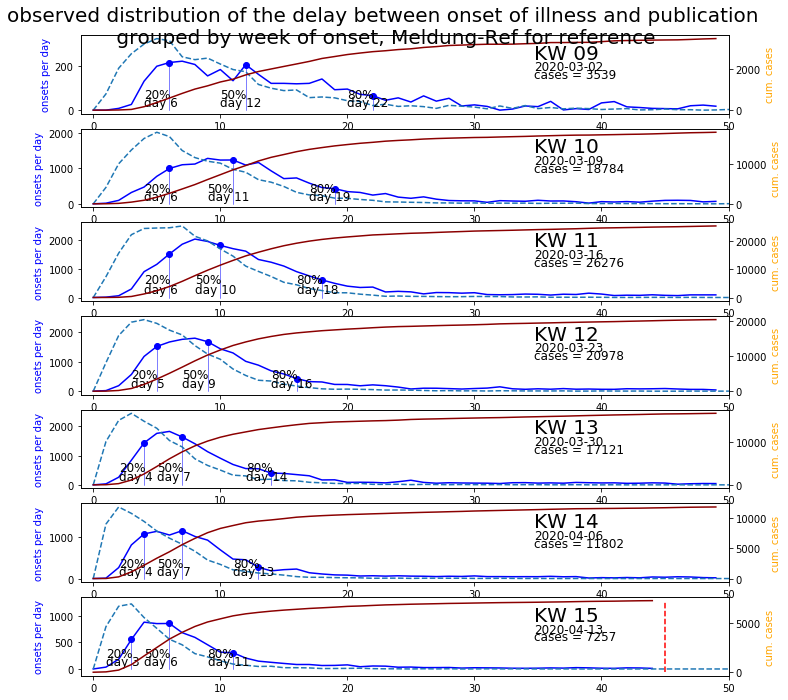

In [20]:
n_weeks = 7
kws = sorted(by_onset_in_kw.keys())[:n_weeks]
# Calculate Levels

levels = [.2,.5,.8]
levels_per_week,levels_per_week_MD = {},{}
for jkw,ikw in enumerate(kws):
    onsets = by_onset_in_kw[ikw]
    cs = np.cumsum(onsets)
    cl = dict(zip(levels,[0]*len(levels))) # Empty dict of discovered levels

    for i,cases in enumerate(cs):
        for l in cl.keys():
            if cases < cs[-1]*l:
                cl[l] = i
    levels_per_week[ikw] = cl
    
print(levels_per_week)
print(melde_delay_by_onset.keys())
    
# Plot
fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(wspace=0.33,hspace=0.19,left=0.08,right=0.98,top=0.94,bottom=0.05)
fig.suptitle("observed distribution of the delay between onset of illness and publication\n grouped by week of onset, Meldung-Ref for reference",fontsize=20)

end_data = onset_start + datetime.timedelta(days=onsets_per_date.shape[0])
max_days = 50

gs = fig.add_gridspec(len(kws), 1)

for jkw,ikw in enumerate(kws):
    onsets = by_onset_in_kw[ikw]
    max_onsets = np.max(onsets)
    ax = fig.add_subplot(gs[jkw,0])
    cs = np.cumsum(onsets)
    
    kw_end_data = KWs[ikw]+datetime.timedelta(days=max_days)
    no_data_days = (end_data-kw_end_data).days
    end = min(max_days,max_days+no_data_days)
    
    ax.text(0.7,.7,"KW %02d"%ikw,transform=ax.transAxes,fontsize=20)
    ax.text(0.7,.55,"%s"%(KWs[ikw]),transform=ax.transAxes,fontsize=12)
    ax.text(0.7,.45,"cases = %d"%(cs[-1]),transform=ax.transAxes,fontsize=12)
    
    for ll,lv in levels_per_week[ikw].items():
        ax.plot([lv],onsets[lv],"o",color="blue")
        ax.plot([lv]*2,[0,onsets[lv]],color="blue",linewidth=.5)
        ax.text(lv-2,max_onsets/4.,"%d%%"%(ll*100),fontsize=12)
        ax.text(lv-2,max_onsets/12.,"day %d"%(lv),fontsize=12)
        
    ax.plot(range(end),onsets[:end],color="blue",label="onsets per day [left]")
    
    ax.plot(melde_delay_by_onset[ikw],"--")

    if no_data_days < 0:
        ax.plot([end]*2,ax.get_ylim(),"--",color="red")
    
    ax.set_ylabel("onsets per day",color="blue")
    ax.set_xlim(-1,max_days)
    
    bx = ax.twinx()
    bx.plot(range(end),cs[:end],color="darkred",label="cum. onsets [right]")
    bx.set_ylabel("cum. cases",color="orange")
    bx.set_xlim(-1,max_days)

    

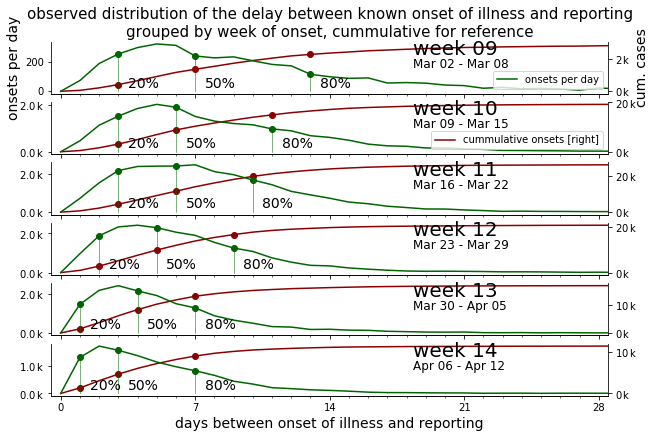

In [21]:
### Actual figure for the comments
n_weeks = 6
kws = sorted(by_onset_in_kw.keys())

# Calculate Levels
levels = [.2,.5,.8]
levels_per_week,levels_per_week_MD = {},{}
for jkw,ikw in enumerate(kws):
    onsets = melde_delay_by_onset[ikw]
    cs = np.cumsum(onsets)
    cl = dict(zip(levels,[0]*len(levels))) # Empty dict of discovered levels

    for i,cases in enumerate(cs):
        for l in cl.keys():
            if cases < cs[-1]*l:
                cl[l] = i
    levels_per_week[ikw] = cl
    
# Plot
fig = plt.figure(figsize=(9,6))
fig.subplots_adjust(wspace=0.33,hspace=0.16,left=0.07,right=0.93,top=0.9,bottom=0.08)
fig.suptitle("observed distribution of the delay between known onset of illness and reporting\ngrouped by week of onset, cummulative for reference",fontsize=15)

end_data = onset_start + datetime.timedelta(days=onsets_per_date.shape[0])
max_days = 30

gs = fig.add_gridspec(n_weeks, 1)

for jkw,ikw in enumerate(kws[:n_weeks]):
    onsets = melde_delay_by_onset[ikw]
    max_onsets = np.max(onsets)
    ax = fig.add_subplot(gs[jkw,0])
    cs = np.cumsum(melde_delay_by_onset[ikw])
    bx = ax.twinx()
    
    
    bx.plot(range(end),cs[:end],color="darkred",label="cummulative onsets [right]",zorder=-1)
    if jkw == 1:
        ax.plot([0],[0],color="darkred",label="cummulative onsets [right]")
    bx.set_xlim(-1,max_days)


    
    kw_end_data = KWs[ikw]+datetime.timedelta(days=max_days)
    no_data_days = (end_data-kw_end_data).days
    end = min(max_days,max_days+no_data_days)
    
    ax.text(0.65,.75,"week %02d"%ikw,transform=ax.transAxes,fontsize=20)
    ax.text(0.65,.5,"%s"%(KWss[ikw]),transform=ax.transAxes,fontsize=12)
#    ax.text(0.7,.45,"cases = %d"%(cs[-1]),transform=ax.transAxes,fontsize=12)
    
    
    for ll,lv in levels_per_week[ikw].items():
        ax.plot([lv],onsets[lv],"o",color="darkgreen")
        bx.plot([lv],cs[lv],"o",color="darkred")
        ax.plot([lv]*2,[0,onsets[lv]],color="darkgreen",linewidth=.5)
        ax.text(lv+.5,max_onsets/12.,"%d%%"%(ll*100),fontsize=14,zorder=5)
#        ax.text(lv+.5,max_onsets/12.,"day %d"%(lv),fontsize=14)
        
 #   ax.plot(range(end),onsets[:end],color="blue",label="onsets per day [left]")
    l = "onsets per day" if jkw == 0 else None
    ax.plot(melde_delay_by_onset[ikw],color="darkgreen",label=l)#,label="onsets per day")
    if jkw == 0:
        ax.set_ylabel("onsets per day",color="black",fontsize=14)#"blue"
        bx.set_ylabel("cum. cases",color="black",fontsize=14)#"orange"

    ax.set_xlim(-1,max_days)
    
    

    if jkw in [0,1]:
        ax.legend(loc=4)
        
    for tx in [ax,bx]:
        prec = 1.0 / (np.log10(tx.get_ylim()[1]) - 2.5)
        if prec < 2.0 and prec >= 0:
            tx.yaxis.set_major_formatter(
                matplotlib.ticker.FuncFormatter(_format_k(int(prec)))
            )    
    
    ax.set_xticks([0,7,14,21,28])
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    if jkw == n_weeks-1:
        ax.set_xticklabels([0,7,14,21,28])
        ax.set_xlabel("days between onset of illness and reporting",fontsize=14)
    else:
        ax.set_xticklabels([None]*5)
    ax.set_xlim(-0.5,28.5)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    bx.spines['top'].set_visible(False)
    bx.spines['left'].set_visible(False)
    
    ax.set_zorder(bx.get_zorder()+1)
    ax.patch.set_visible(False)

fig.savefig("FigReportingDelayByWeeks.svg")
fig.savefig("FigReportingDelayByWeeks.pdf")

{9: {0.2: 3, 0.5: 7, 0.8: 13}, 10: {0.2: 3, 0.5: 6, 0.8: 11}, 11: {0.2: 3, 0.5: 6, 0.8: 10}, 12: {0.2: 2, 0.5: 5, 0.8: 9}, 13: {0.2: 1, 0.5: 4, 0.8: 7}, 14: {0.2: 1, 0.5: 3, 0.8: 7}, 15: {0.2: 1, 0.5: 3, 0.8: 6}, 16: {0.2: 1, 0.5: 2, 0.8: 5}, 17: {0.2: 1, 0.5: 3, 0.8: 6}, 18: {0.2: 1, 0.5: 2, 0.8: 5}, 19: {0.2: 1, 0.5: 2, 0.8: 5}, 20: {0.2: 1, 0.5: 1, 0.8: 3}}
[9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] 0.8 [13, 11, 10, 9, 7, 7, 6, 5, 6, 5, 5, 3]
[9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] 0.5 [7, 6, 6, 5, 4, 3, 3, 2, 3, 2, 2, 1]
[9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] 0.2 [3, 3, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1]


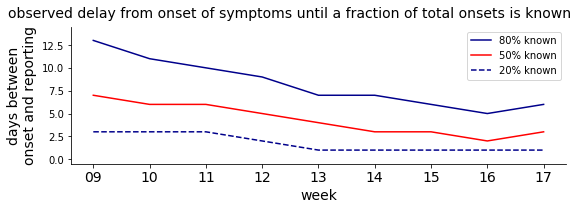

In [22]:
# Transpose levels:
t_levels = {}
for l in levels:
    t_levels[l] = []
for kw in kws:
    for k,v in levels_per_week[kw].items():
        t_levels[k].append(v)

print(levels_per_week)
# Plot
fig = plt.figure(figsize=(8,2.8))
fig.subplots_adjust(wspace=0.33,hspace=0.17,left=0.12,right=0.98,top=0.88,bottom=0.2)
fig.suptitle("observed delay from onset of symptoms until a fraction of total onsets is known",fontsize=14)

gs = fig.add_gridspec(1, 1)
ax = fig.add_subplot(gs[0,0])
full_end = kws[-1]-3
#ax.plot([full_end]*2,[0,30],"--",color="red")
#ax.text(full_end+.2,20,"distorted as total number\nmightincrease for 30 days",color="red",fontsize=13)
#ax.text(full_end-.2,20,"total numner\nconsidered reliable",color="red",fontsize=13,horizontalalignment="right")

dks = list(t_levels.keys())
for k,c,l in zip(reversed(dks),["darkblue","red","darkblue"][::-1],["--","-","-"][::-1]):
    v = t_levels[k]
    print(kws,k,v)
    ax.plot(kws[:-3],v[:-3],l,label="%d%% known"%(k*100),color=c)

    
ax.set_xticks(kws[:-3])
ax.set_xticklabels(["%02d"%x for x in kws[:-3] ],fontsize=14)
ax.set_xlabel("week",fontsize=14)
ax.set_ylabel("days between\nonset and reporting",fontsize=14)
ax.legend()
ax.set_ylim(-0.5,14.5)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
    

fig.savefig("FigReportingDelayPerWeek.svg")
fig.savefig("FigReportingDelayPerWeek.pdf")

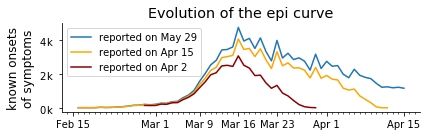

In [79]:
from covid19_inference import plot as covplt
covplt.set_rcparams(covplt.get_rcparams_default())

fig, ax = plt.subplots(1,1,figsize=(6.1,2))
fig.subplots_adjust(wspace=0.33,hspace=0.19,left=0,right=0.6,top=0.88,bottom=0.14)
ax.set_title("Evolution of the epi curve",size="x-large")

ticks = [datetime.date(2020,2,15),datetime.date(2020,3,1),datetime.date(2020,3,9),datetime.date(2020,3,16),datetime.date(2020,3,23),datetime.date(2020,4,1),datetime.date(2020,4,15)]
tick_labels = ["Feb 15","Mar 1","Mar 9","Mar 16","Mar 23","Apr 1","Apr 15"]

pub_dates = [datetime.date(2020,4,2),datetime.date(2020,4,15),datetime.date(2020,5,29)]
ts = pd.date_range(onset_start,periods=60,freq='D')

for pub_date,c,d in zip(pub_dates[::-1],["tab:blue","orange","darkred"],["Apr 2","Apr 15","May 29"][::-1]):
    idate = (pub_date-publishing_start).days
    opd = ma.masked_where(onsets_per_date == 0, onsets_per_date)
    covplt._timeseries(x=ts,
                       y=opd[:len(ts),idate-2],
                       ax=ax,
                       label="reported on %s"%(d),
                       color=c,
                       what="model")
    
ax.legend()
ax.set_xticks(ticks)
ax.set_xticklabels(tick_labels)
ax.set_ylabel("known onsets\nof symptoms",size="large")


for tx in [ax]:
    prec = 1.0 / (np.log10(tx.get_ylim()[1]) - 2.5)
    if prec < 2.0 and prec >= 0:
        tx.yaxis.set_major_formatter(
            matplotlib.ticker.FuncFormatter(_format_k(int(prec)))
        )
#ax.axis('off')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.tight_layout()
#plt.subplots_adjust(right=0.5)
fig.savefig("FigEpiCurveKnownAt.svg")
fig.savefig("FigEpiCurveKnownAt.pdf")